## POC

In [1]:
import torch
from torch import nn

In [2]:
class SmolNet(nn.Module):
    def __init__(self) -> None:
        super(SmolNet, self).__init__()
        self.fc1 = nn.Linear(10, 20)
        self.fc2 = nn.Linear(20, 30)
        self.fc3 = nn.Linear(30, 5)

    def forward(self, x):
        x = self.fc1(x)
        x = self.fc2(x)
        x = self.fc3(x)
        return x

In [3]:
smol = SmolNet()
smol

SmolNet(
  (fc1): Linear(in_features=10, out_features=20, bias=True)
  (fc2): Linear(in_features=20, out_features=30, bias=True)
  (fc3): Linear(in_features=30, out_features=5, bias=True)
)

In [4]:
def hook(self, input, output):
    print(output.data)

In [5]:
smol.fc3.register_forward_hook(hook)

In [6]:
smol(torch.rand(10))

tensor([-0.2242,  0.1860, -0.0146, -0.1434,  0.1195])


tensor([-0.2242,  0.1860, -0.0146, -0.1434,  0.1195], grad_fn=<AddBackward0>)

## ResNet

In [1]:
import torch
import matplotlib.pyplot as plt
import numpy as np
from tempo.data.datasets import finetune_dataset
from tempo.models import NewTempoLinear

In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f'Using device: {device}.')

Using device: cuda.


In [3]:
train_loader_ft = finetune_dataset(name='ASL-big', train=True, batch_size=10)
test_loader_ft = finetune_dataset(train=False, batch_size=10)

In [4]:
weights = torch.load("./model_zoo/baseline.pth")
model = NewTempoLinear(out_features=24, weights=None, freeze_backbone=True)
model.load_state_dict(weights)
_ = model.to(device)

In [11]:
from linear_eval import linear_eval_new

In [12]:
losses, errors, iters = linear_eval_new(3_000, model, train_loader_ft, test_loader_ft, device)

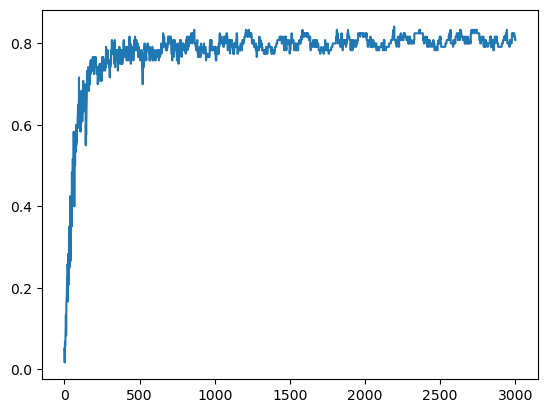

In [13]:
plt.plot(iters, errors)

In [1]:
import torch
import matplotlib.pyplot as plt
import numpy as np
from tempo.data.datasets import finetune_dataset
from tempo.models import NewTempoLinear

In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f'Using device: {device}.')

Using device: cuda.


In [3]:
train_loader_ft = finetune_dataset(name='ASL-big', train=True, batch_size=10)
test_loader_ft = finetune_dataset(train=False, batch_size=10)

In [4]:
weights = torch.load("./model_zoo/baseline.pth")
model = NewTempoLinear(out_features=24, weights=None, freeze_backbone=True)
model.load_state_dict(weights)
_ = model.to(device)

In [5]:
def get_features(reps, layer):
    def hook(model, input, output):
        reps[layer].append(output.data)
    return hook

In [6]:
reps = {
    'l1': [],
    'l2': [],
    'l3': [],
    'l4': [],
}

test_reps = {
    'l1': [],
    'l2': [],
    'l3': [],
    'l4': [],
}

In [7]:
model.backbone[6].register_forward_hook(get_features(reps, 'l3'))
model.backbone.register_forward_hook(get_features(reps, 'l4'))

In [8]:
# Compute all representations

with torch.no_grad():
    for input, label in train_loader_ft:

        repr = model.backbone(input.to(device)).detach()
        repr = torch.flatten(repr, start_dim=1)
        # reps.append((repr, label.to(device)))

    # for input, label in test_loader_ft:
    #     repr = model.backbone(input.to(device)).detach()
    #     repr = torch.flatten(repr, start_dim=1)
    #     test_reps.append((repr, label.to(device)))

In [9]:
torch.cat(reps['l3'], dim=0).shape

torch.Size([3750, 256, 8, 8])

In [10]:
torch.cat(reps['l4'], dim=0).shape

torch.Size([3750, 512, 1, 1])